In [5]:
root = '/content/drive/My Drive/nlp-lab'
datasets_location = root + '/data/original-datasets/amazon-german-dataset1'
processed_data_location = root + '/data/processed-data/amazon-german1'

In [6]:
import nltk
nltk.download('punkt')
import pandas as pd
import gzip
import math
import numpy as np
from google.colab import drive
from sys import path
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import lxml

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
drive.mount('/content/drive', force_remount=True)
path.append(root)

Mounted at /content/drive


In [ ]:
#Donwload dataset
#wget -O /var/cache/foobar/stackexchange-site-list.txt http://url.to/stackexchange-site-list.txt
#!ls "$datasets_location"
#donwload_location = datasets_location + "/amazon_reviews_multilingual_DE_v1_00.tsv.gz"
#!wget -O "$donwload_location" https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_multilingual_DE_v1_00.tsv.gz
#!tar xvzf "$donwload_location" -C "$datasets_location"
#print(donwload_location)
#print(datasets_location)

In [8]:
reviews_df = pd.read_csv(datasets_location + "/amazon_reviews_multilingual_DE_v1_00.tsv", sep='\t', header=0)

In [9]:
#Data exploration
print(reviews_df.shape[0])
categories = reviews_df["product_category"].unique()
counts = reviews_df["product_category"].value_counts()
#counts
#len(categories)
categories

678993


array(['Home Improvement', 'Books', 'Video DVD', 'Digital_Video_Download',
       'Watches', 'Mobile_Apps', 'PC', 'Music', 'Electronics',
       'Video Games', 'Toys', 'Digital_Music_Purchase',
       'Digital_Ebook_Purchase', 'Sports', 'Wireless', 'Luggage', 'Shoes',
       'Health & Personal Care', 'Home', 'Musical Instruments',
       'Office Products', 'Home Entertainment',
       'Personal_Care_Appliances', 'Video', 'Camera', 'Kitchen', 'Baby',
       'Automotive', 'Lawn and Garden', 'Furniture', 'Software', 'Beauty',
       'Pet Products', 'Grocery'], dtype=object)

In [10]:
relevant_categories = ["Health & Personal Care", "Personal_Care_Appliances","Beauty","Grocery"]
reviews_filtered_df = reviews_df.loc[reviews_df['product_category'].isin(relevant_categories)]
counts = reviews_filtered_df["product_category"].value_counts()
counts

Personal_Care_Appliances    411
Health & Personal Care       37
Grocery                       2
Beauty                        1
Name: product_category, dtype: int64

In [13]:
def getSentimentFromRating(rating):

    sentiment = "0"
    
    if rating < 3:
        sentiment = "n"
    elif rating == math.floor(3):
        sentiment = "0"
    else:
        sentiment = "p"
    
    return sentiment

In [14]:
def processDataFrame(dataframe):
    
    processed_df = pd.DataFrame(columns = ['comment_id','sentence_id','comment_rating','comment_sentiment','sentence_text','number_of_tokens','dataset_name'])
    number_of_rows = dataframe.shape[0]

    counter = 0
    for index, row in dataframe.iterrows():
        
        if counter%100 == 0:
            print('processed rows: ' + str(counter) + '/' + str(number_of_rows) + ' - percentage: ' + str(math.floor((counter/number_of_rows)*100)) + '%')
        counter += 1
        
        clean_text = BeautifulSoup(row["review_body"],"lxml").text
        
        sentences = nltk.sent_tokenize(clean_text,language='german')
        comment_rating = row["star_rating"]
        comment_sentiment = getSentimentFromRating(comment_rating)
        dataset_name = row["product_category"]
    
        sentence_id = 0
        for sentence in sentences: 
            number_of_tokens = len(nltk.word_tokenize(sentence,language='german'))
            processed_df.loc[len(processed_df)] = [index,sentence_id,comment_rating,comment_sentiment,sentence,number_of_tokens,dataset_name]
            sentence_id += 1
            
    print('dataset processed')
            
    return processed_df

In [15]:
#complete_data_df_processed = processDataFrame(complete_data_df)
#reviews_filtered_df.reset_index()
complete_data_df_processed = processDataFrame(reviews_filtered_df)
#reviews_filtered_df

processed rows: 0/451 - percentage: 0%
processed rows: 100/451 - percentage: 22%
processed rows: 200/451 - percentage: 44%
processed rows: 300/451 - percentage: 66%
processed rows: 400/451 - percentage: 88%
dataset processed


In [ ]:
complete_data_df_processed = complete_data_df_processed[complete_data_df_processed['number_of_tokens'].apply(lambda x: x < 100)]

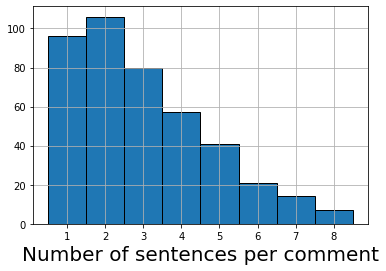

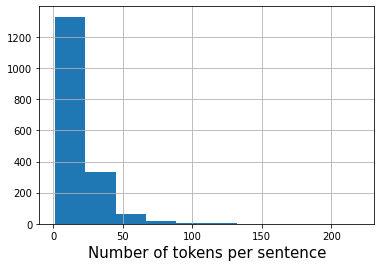

In [16]:
#Number of sentences per comment
number_of_sentences_plot = complete_data_df_processed.groupby(['comment_id']).size().hist(bins=np.arange(0,9)+0.5, ec="k")
number_of_sentences_plot.set_xlabel("Number of sentences per comment",fontsize=20)
plt.show()

#Number of tokens per sentence
tokens_per_sentence_plot = complete_data_df_processed["number_of_tokens"].hist() #Clearly, there are some outliers
tokens_per_sentence_plot.set_xlabel("Number of tokens per sentence",fontsize=15)
plt.show()
#0.11419957517% of the dataset has more than 200 tokens
#0.1964232693of the dataset has more than 100 tokens

In [17]:
#Number of positive, negative and neutral sentiments in comments
ratings = reviews_df.groupby(['star_rating']).size()
ratings

star_rating
1     49273
2     33490
3     53201
4    104168
5    438861
dtype: int64

In [18]:
#Number of positive, negative and neutral sentiments in comments
ratings = reviews_filtered_df.groupby(['star_rating']).size()
ratings

star_rating
1     35
2     25
3     40
4     60
5    291
dtype: int64

In [ ]:
complete_data_df_processed.to_json(processed_data_location + '/processed_data_without_embeddings_no_outliers.json')